In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from glicko2 import Player

In [4]:
csv_path='data/0823.csv'

In [5]:

# モデルのレーティングを保持する辞書
models = {}

# レーティング変更履歴を保存するリスト
rating_history = []

def get_or_create_player(model_name):
    if model_name not in models:
        models[model_name] = Player(rating=1500, rd=350, vol=0.06)
    return models[model_name]

def update_ratings(model1, model2, result, index):
    player1 = get_or_create_player(model1)
    player2 = get_or_create_player(model2)
    
    # 更新前のレーティングとRDを保存
    rating1, rd1 = player1.rating, player1.rd
    rating2, rd2 = player2.rating, player2.rd
    
    # result: 1 = model1の勝利, 0.5 = 引き分け, 0 = model2の勝利
    player1.update_player([rating2], [rd2], [result])
    player2.update_player([rating1], [rd1], [1 - result])
    
    # レーティング変更履歴を保存
    rating_history.append({
        'index': index,
        'model1': model1,
        'model2': model2,
        'rating1_before': rating1,
        'rating1_after': player1.rating,
        'rating2_before': rating2,
        'rating2_after': player2.rating,
        'result': result
    })


In [6]:

# CSVファイルを読み込む
with open(csv_path, 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    next(reader)  # ヘッダーをスキップ
    
    for index, row in enumerate(reader, start=1):
        try:
            evaluation = int(row[3])
        except:
            continue  # 評価が空白のものはスキップ
        model1 = row[5]
        model2 = row[6]
        
        if evaluation == 1:
            update_ratings(model1, model2, 1, index)
        elif evaluation == 2:
            update_ratings(model1, model2, 0, index)
        elif evaluation == 3:  # 両方良い場合（引き分け）
            update_ratings(model1, model2, 0.5, index)
        # evaluation が 0 の場合は更新しない（両方悪い場合）


In [49]:

# 結果をレーティング順にソートして表示
print("Model Ratings (sorted by rating):")
sorted_models = sorted(models.items(), key=lambda x: x[1].rating, reverse=True)

sorted_data=[]
for model, player in sorted_models:
    rating = player.rating
    rd = player.rd
    lower_bound = rating - 2 * rd
    upper_bound = rating + 2 * rd
    print(f"{model}: Rating = {rating:.2f}, RD = {rd:.2f} (95% CI: {lower_bound:.2f} - {upper_bound:.2f})")

    if model.find("/")!=-1:
        model_=model.split("/")[1]
    else:
        model_=model
    if model.find("plamo")!= -1:
        model_="PLAMO-100B"
    model_=model_.replace("gpt","GPT")
    model_=model_.replace("3-5","3.5")
    #先頭文字は大文字
    model_=model_[0].upper()+model_[1:]
    d={"name":model_,"rating":rating,"rd":rd,"lower_bound":lower_bound,"upper_bound":upper_bound}
    sorted_data.append(d)

"""
# レーティング変更履歴をCSVファイルに保存
with open('data/rating_history.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=[
        'index', 'model1', 'model2', 'rating1_before', 'rating1_after',
        'rating2_before', 'rating2_after', 'result'
    ])
    writer.writeheader()
    writer.writerows(rating_history)

print("Rating history has been saved to 'rating_history.csv'")
"""

Model Ratings (sorted by rating):
gpt-4o-2024-05-13: Rating = 1691.91, RD = 65.82 (95% CI: 1560.26 - 1823.55)
gemini-1.5-pro: Rating = 1605.49, RD = 65.15 (95% CI: 1475.19 - 1735.79)
claude-3-5-sonnet-20240620: Rating = 1584.54, RD = 75.11 (95% CI: 1434.31 - 1734.77)
team-hatakeyama-phase2/Tanuki-8x8B-dpo-v1.0: Rating = 1581.93, RD = 62.66 (95% CI: 1456.60 - 1707.25)
gemini-1.5-flash: Rating = 1531.13, RD = 64.01 (95% CI: 1403.11 - 1659.15)
gpt-4o-mini-2024-07-18: Rating = 1524.43, RD = 63.17 (95% CI: 1398.09 - 1650.77)
weblab-GENIAC/Tanuki-8B-dpo-v1.0: Rating = 1476.17, RD = 63.66 (95% CI: 1348.86 - 1603.48)
cyberagent/calm3-22b-chat: Rating = 1468.31, RD = 62.70 (95% CI: 1342.91 - 1593.71)
plamo-beta: Rating = 1435.39, RD = 63.39 (95% CI: 1308.60 - 1562.17)
elyza/Llama-3-ELYZA-JP-8B: Rating = 1398.50, RD = 65.51 (95% CI: 1267.49 - 1529.52)
karakuri-ai/karakuri-lm-8x7b-chat-v0.1: Rating = 1380.63, RD = 66.42 (95% CI: 1247.78 - 1513.48)
tokyotech-llm/Llama-3-Swallow-70B-Instruct-v0.1: 

'\n# レーティング変更履歴をCSVファイルに保存\nwith open(\'data/rating_history.csv\', \'w\', newline=\'\', encoding=\'utf-8\') as file:\n    writer = csv.DictWriter(file, fieldnames=[\n        \'index\', \'model1\', \'model2\', \'rating1_before\', \'rating1_after\',\n        \'rating2_before\', \'rating2_after\', \'result\'\n    ])\n    writer.writeheader()\n    writer.writerows(rating_history)\n\nprint("Rating history has been saved to \'rating_history.csv\'")\n'

Text(0, 0.5, 'Model name')

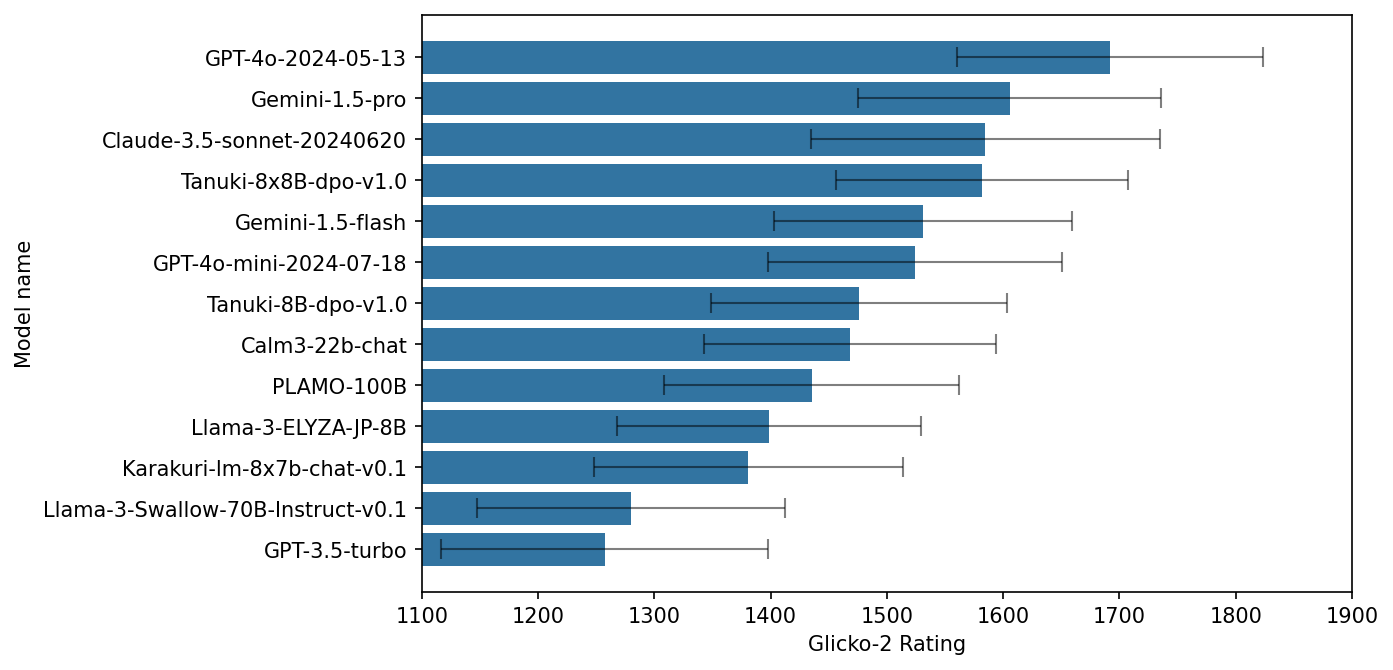

In [51]:
df=pd.DataFrame(sorted_data)
plt.figure(figsize=(8,5),dpi=150)
sns.barplot(x="rating",y="name",data=df)
#エラーバーを表示. プロットは打たない
plt.errorbar(df["rating"],df["name"],xerr=df["rd"]*2,fmt='None',color='black',capsize=5,elinewidth=1,alpha=0.5)
plt.xlim(1100,1900)
plt.xlabel("Glicko-2 Rating")
plt.ylabel("Model name")

Text(0, 0.5, 'Model name')

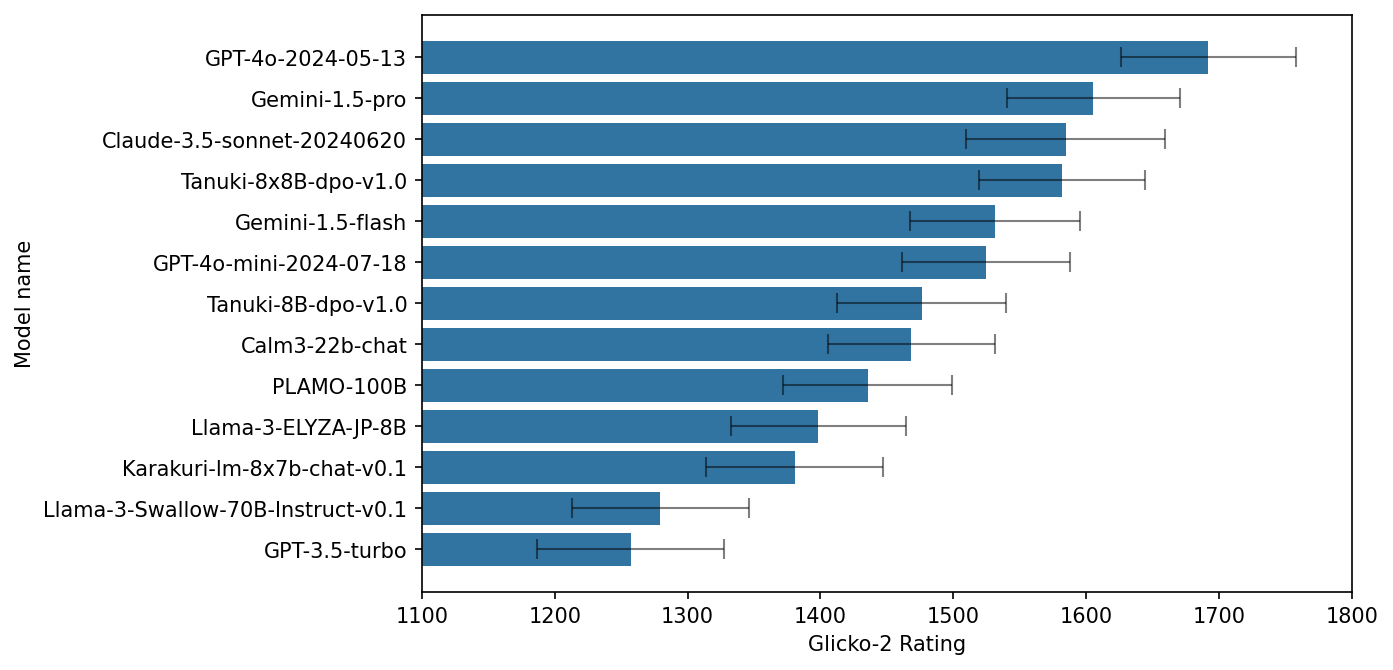

In [52]:
df=pd.DataFrame(sorted_data)
plt.figure(figsize=(8,5),dpi=150)
sns.barplot(x="rating",y="name",data=df)
#エラーバーを表示. プロットは打たない
plt.errorbar(df["rating"],df["name"],xerr=df["rd"],fmt='None',color='black',capsize=5,elinewidth=1,alpha=0.5)
plt.xlim(1100,1800)
plt.xlabel("Glicko-2 Rating")
plt.ylabel("Model name")